In [1]:
import open3d as o3d
import open3d.core as o3c
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Using external Open3D-ML in /root/Open3D-ML


# PointCloud
This tutorial demonstrates basic usage of a point cloud.

## PointCloud creation
The first part of the tutorial shows how to construct a point cloud.

In [38]:
# Create a empty point cloud on CPU.
pcd = o3d.t.geometry.PointCloud()
print(pcd, '\n')

# Create a empty point cloud on GPU.
pcd = o3d.t.geometry.PointCloud(o3c.Device("CUDA:0"))
print(pcd, '\n')

# Create a point cloud from open3d tensor with data type of float32.
pcd = o3d.t.geometry.PointCloud(o3c.Tensor([[0, 0, 0], [1, 1, 1]], o3c.float32))
print(pcd, '\n')
# Create a point cloud from open3d tensor with data type of float64.
pcd = o3d.t.geometry.PointCloud(o3c.Tensor([[0, 0, 0], [1, 1, 1]], o3c.float64))
print(pcd, '\n')
# Create a point cloud from open3d tensor on GPU.
pcd = o3d.t.geometry.PointCloud(o3c.Tensor([[0, 0, 0], [1, 1, 1]], o3c.float32, o3c.Device("CUDA:0")))
print(pcd, '\n')

# Special creation.
# Create a point cloud from numpy array.
pcd = o3d.t.geometry.PointCloud(np.array([[0, 0, 0], [1, 1, 1]], dtype=np.float32))
print(pcd, '\n')
# Create a point cloud from python list.
pcd = o3d.t.geometry.PointCloud([[0., 0., 0.], [1., 1., 1.]])
print(pcd, '\n')

# Error creation. The point cloud must have shape of (N, 3).
pcd = o3d.t.geometry.PointCloud(o3c.Tensor([0, 0, 0, 0], o3c.float32))

PointCloud on CPU:0 [0 points].
Attributes: None. 

PointCloud on CUDA:0 [0 points].
Attributes: None. 

PointCloud on CPU:0 [2 points (Float32)].
Attributes: None. 

PointCloud on CPU:0 [2 points (Float64)].
Attributes: None. 

PointCloud on CUDA:0 [2 points (Float32)].
Attributes: None. 

PointCloud on CPU:0 [2 points (Float32)].
Attributes: None. 

PointCloud on CPU:0 [2 points (Float64)].
Attributes: None. 



RuntimeError: [1;31m[Open3D Error] (open3d::t::geometry::PointCloud::PointCloud(const open3d::core::Tensor&)) /root/Open3D/cpp/open3d/t/geometry/PointCloud.cpp:72: Tensor has shape {4}, but is expected to have compatible with {None, 3}.
[0;m

The `PointCloud` can be created on both CPU and GPU, and with different data types. The device of the point cloud will be the same as the device of the input tensor.

Besides, `PointCloud` can be also created by python dict with multiple attributes. 

In [37]:
map_to_tensors = {}
# The `positions` attribute must be specified.
map_to_tensors['positions'] = o3c.Tensor([[0, 0, 0], [1, 1, 1]], o3c.float32)
map_to_tensors['normals'] = o3c.Tensor([[0, 0, 1], [0, 0, 1]], o3c.float32)
map_to_tensors['labels'] = o3c.Tensor([0, 1], o3c.int64)

pcd = o3d.t.geometry.PointCloud(map_to_tensors)
print(pcd)

PointCloud on CPU:0 [2 points (Float32)].
Attributes: normals (dtype = Float32, shape = {2, 3}), labels (dtype = Int64, shape = {2}).


## PointCloud attributes setter and getter

In [ ]:
pcd = o3d.t.geometry.PointCloud(o3c.Tensor([[0, 0, 0], [1, 1, 1]], o3c.float32))
# Set attributes.
pcd.point.normals = o3c.Tensor([[0, 0, 1], [0, 0, 1]], o3c.float32)
pcd.point.colors = o3c.Tensor([[1, 0, 0], [0, 1, 0]], o3c.float32)
pcd.point.labels = o3c.Tensor([0, 1], o3c.int64)
print(pcd, '\n')

# Set by numpy array or python list.
pcd.point.normals = np.array([[0, 0, 1], [0, 0, 1]], dtype=np.float32)
pcd.point.intensity = [0.4, 0.4]
print(pcd, '\n')

# Get attributes.
posisions = pcd.point.positions
print('posisions: ')
print(posisions, '\n')
labels = pcd.point.labels
print('labels: ')
print(labels, '')

## Visualize point cloud

Load a ply point cloud, print it, and render it
PointCloud on CPU:0 [196133 points (Float32)].
Attributes: curvature (dtype = Float32, shape = {196133, 1}), normals (dtype = Float32, shape = {196133, 3}), colors (dtype = UInt8, shape = {196133, 3}).


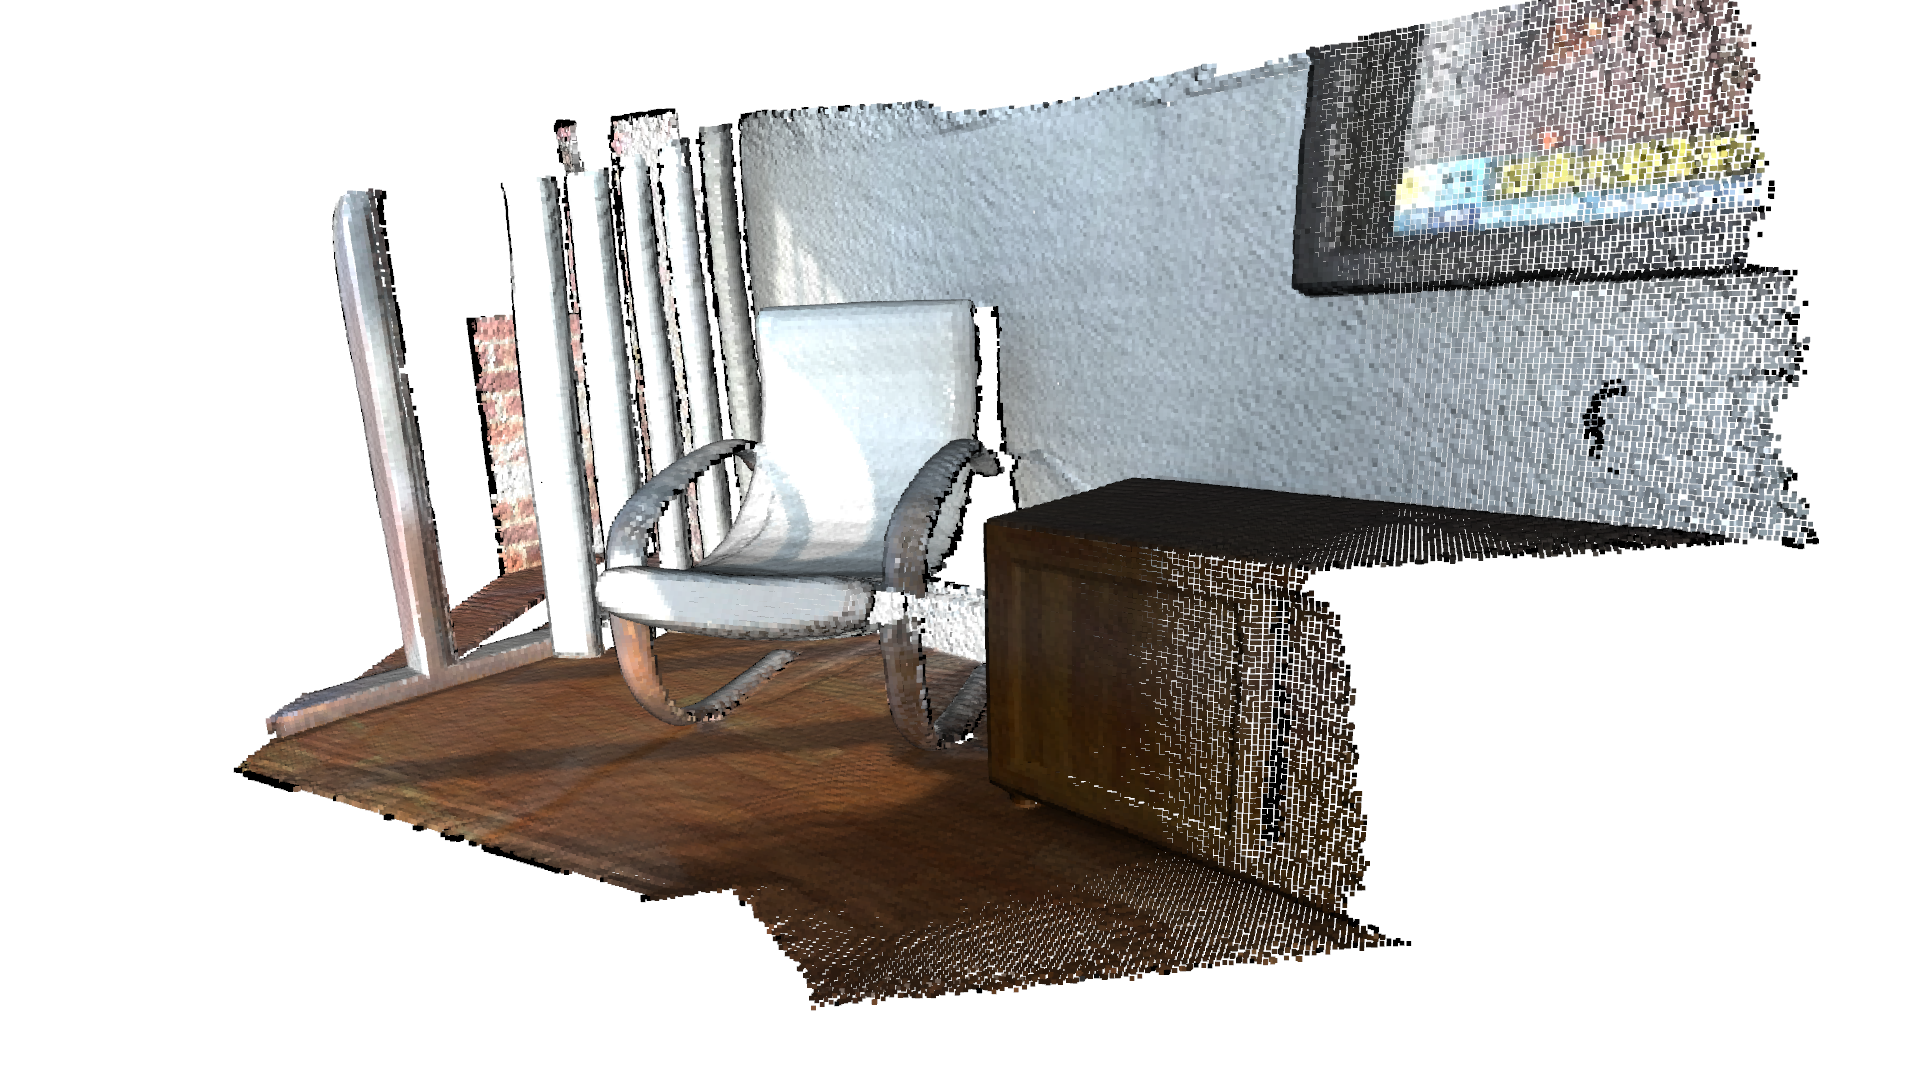

In [4]:
print("Load a ply point cloud, print it, and render it")
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.t.io.read_point_cloud(ply_point_cloud.path)
print(pcd)
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

`read_point_cloud` reads a point cloud from a file. It tries to decode the file based on the extension name. For a list of supported file types, refer to [File IO](file_io.ipynb).

`draw_geometries` visualizes the point cloud. Use a mouse/trackpad to see the geometry from different view points.

It looks like a dense surface, but it is actually a point cloud rendered as surfels. The GUI supports various keyboard functions. For instance, the `-` key reduces the size of the points (surfels).

<div class="alert alert-info">
    
**Note:** 

Press the `H` key to print out a complete list of keyboard instructions for the GUI. For more information of the visualization GUI, refer to [Visualization](visualization.ipynb) and [Customized visualization](../visualization/customized_visualization.rst).

</div>

<div class="alert alert-info">
    
**Note:** 

On macOS, the GUI window may not receive keyboard events. In this case, try to launch Python with `pythonw` instead of `python`.

</div>

## Downsampling
This section provides several downsamle methods of a point cloud.
### Voxel downsampling
Voxel downsampling uses a regular voxel grid to create a uniformly downsampled point cloud from an input point cloud. It is often used as a pre-processing step for many point cloud processing tasks. The algorithm operates in two steps:

1. Points are bucketed into voxels.
2. Each occupied voxel generates exactly one point by averaging all points inside. 

<div class="alert alert-info">
    
**Note:** 

Currently, the method return the voxel coordinates of the point cloud.

</div>

Downsample the point cloud with a voxel of 0.03


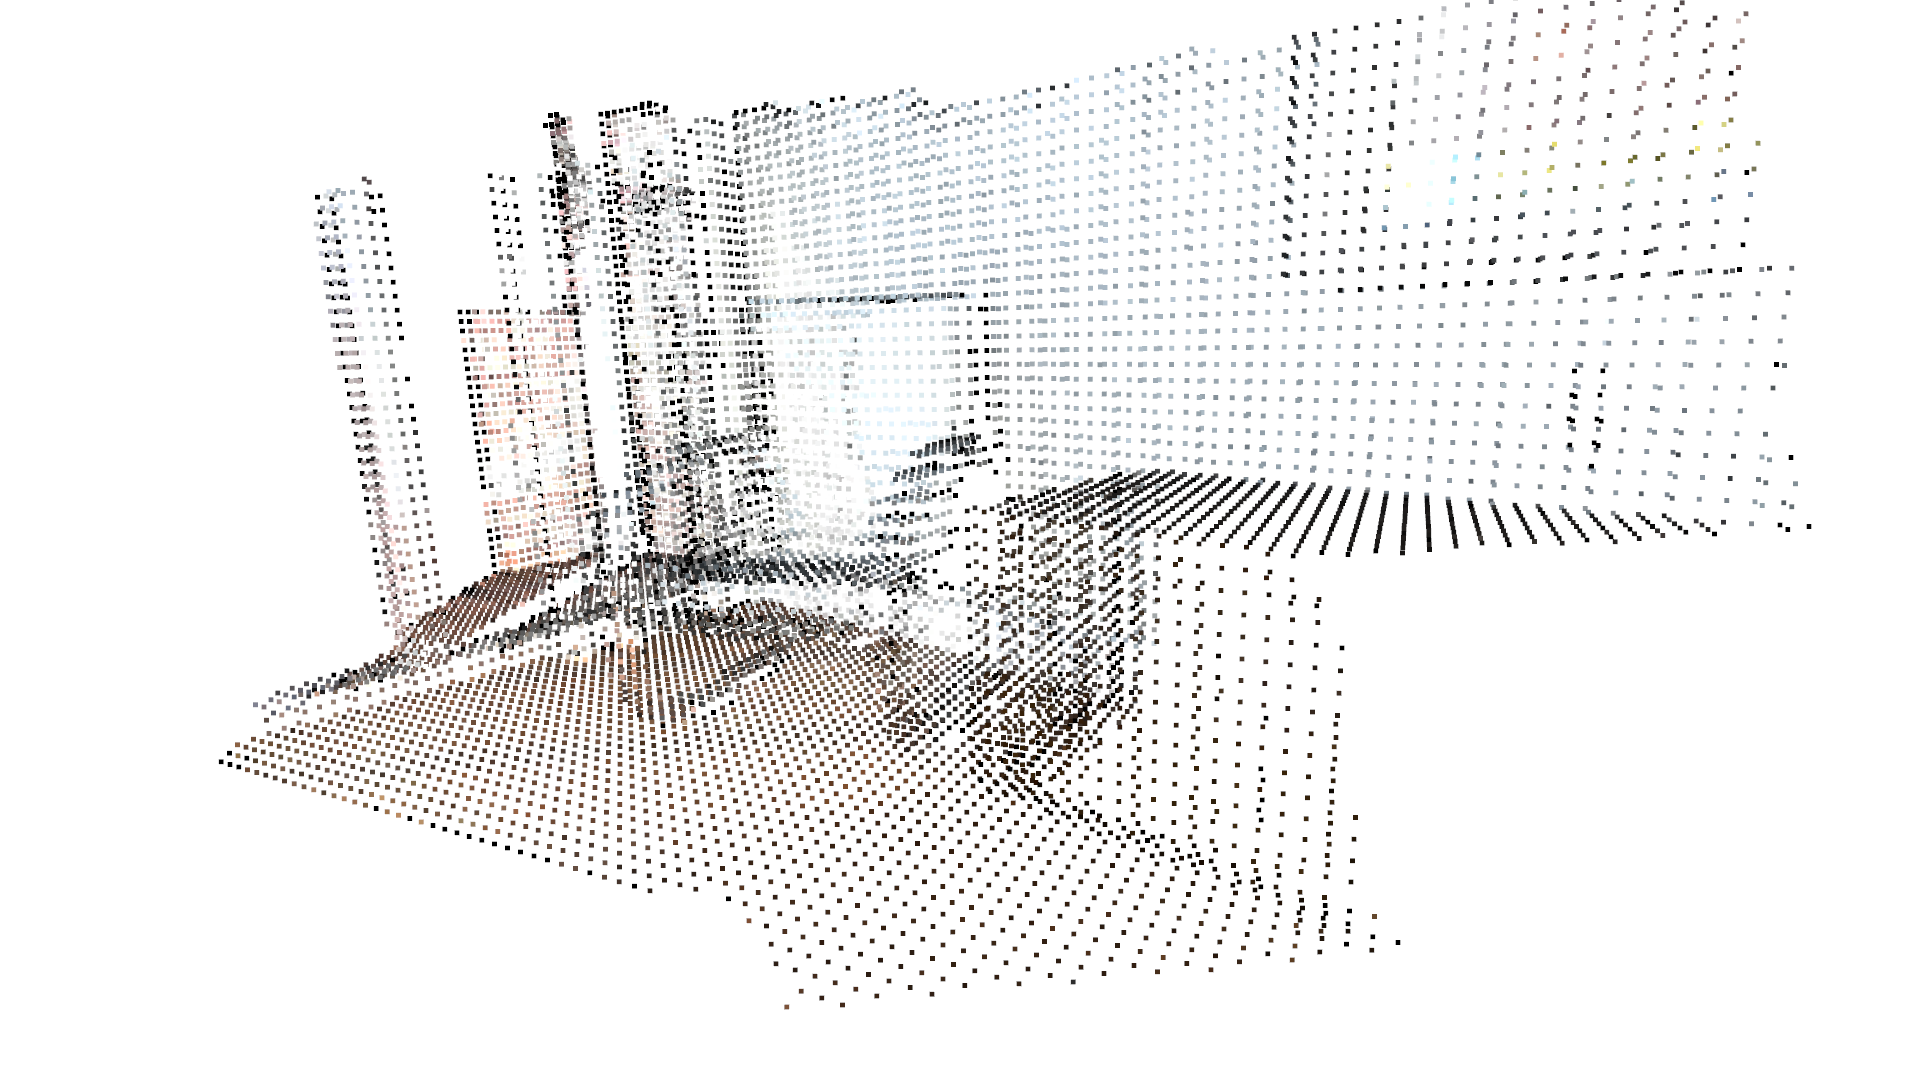

In [6]:
print("Downsample the point cloud with a voxel of 0.03")
downpcd = pcd.voxel_down_sample(voxel_size=0.03)
o3d.visualization.draw_geometries([downpcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

### Farthest point downsampling
Farthest point sampling sample the point cloud by selecting the farthest point from the current selected point cloud iteratively. It is use to sample the point cloud to a fixed number of points which holds the maximum geometrical information of the original point cloud.

Downsample the point cloud by selecting 5000 farthest points.


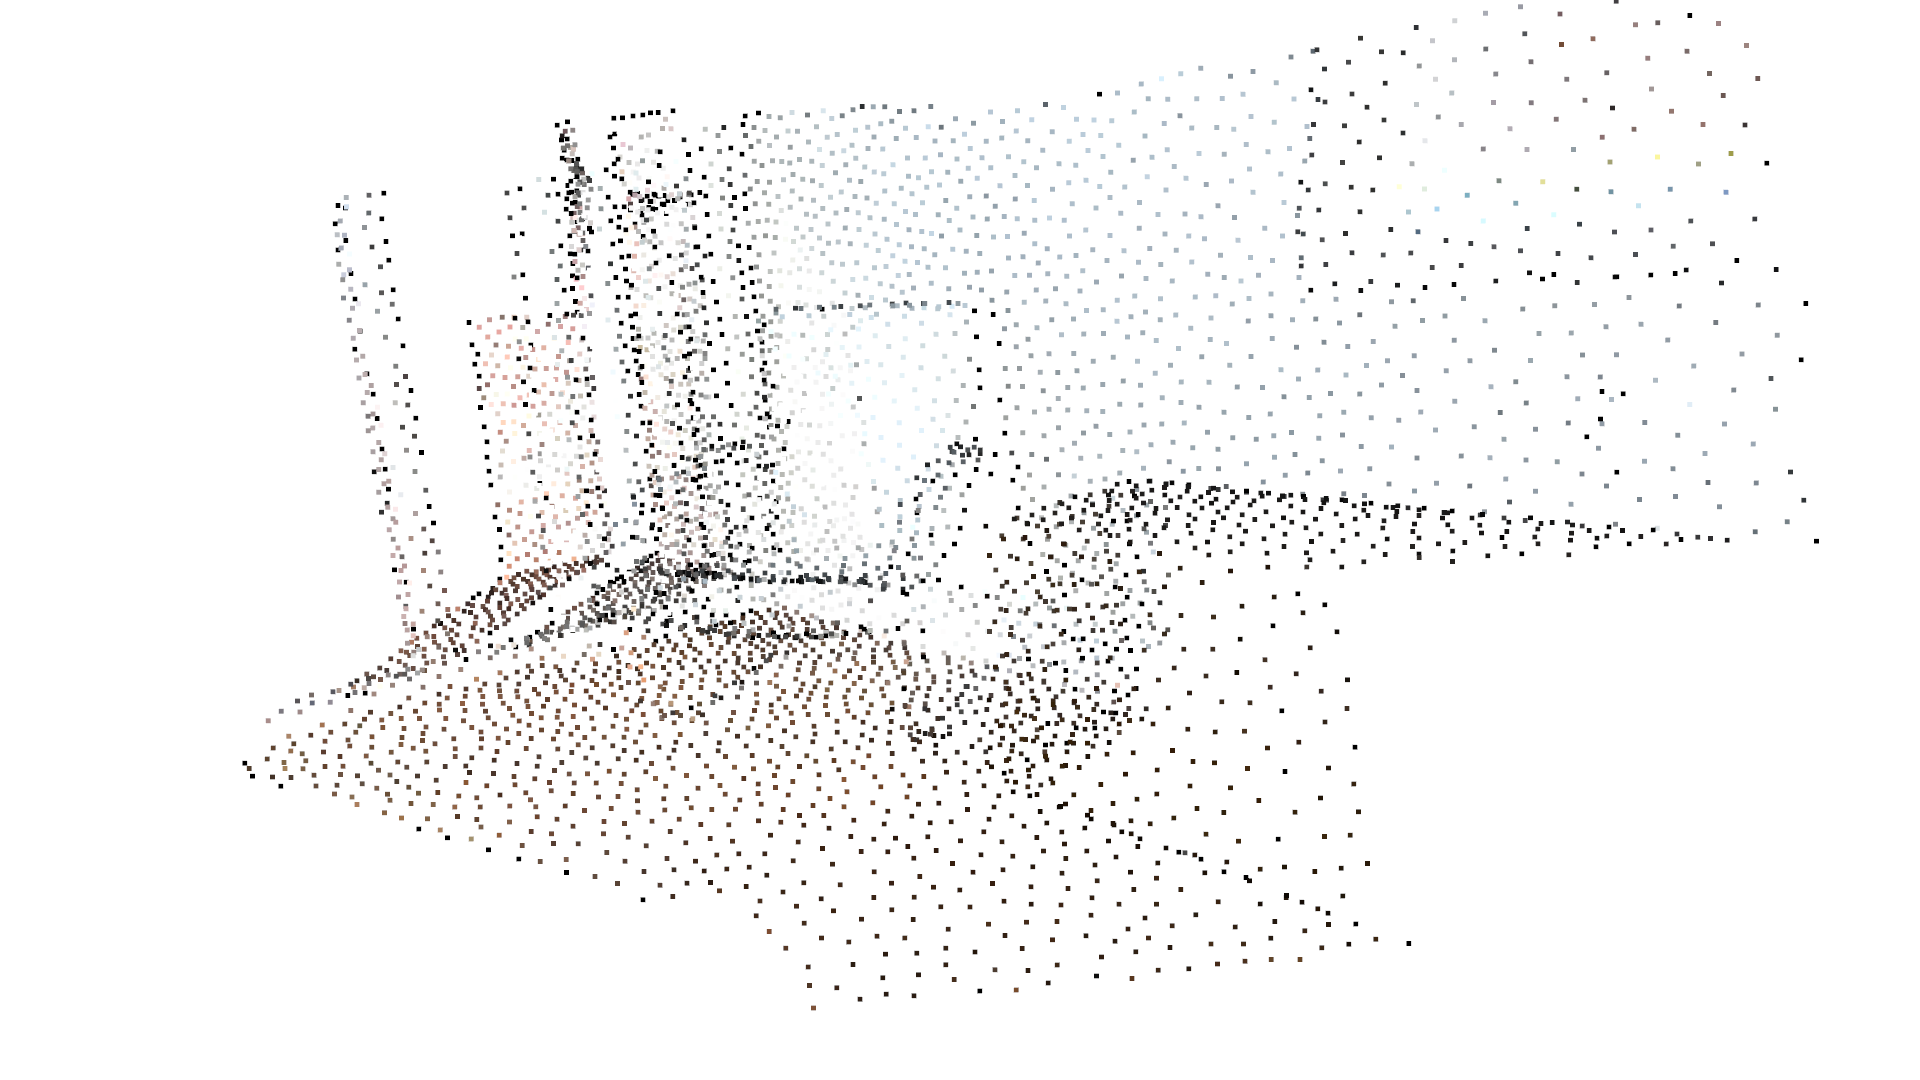

In [5]:
print("Downsample the point cloud by selecting 5000 farthest points.")
downpcd_farthest = pcd.farthest_point_down_sample(5000)
o3d.visualization.draw_geometries([downpcd_farthest.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Open3D also provides `uniform_down_sample` and `random_down_sample` for point cloud downsampling.

## Vertex normal estimation
Another basic operation for point cloud is normal estimation.
Press `N` to see point normals. The keys `-` and `+` can be used to control the length of the normal.

Recompute the normal of the downsampled point cloud using hybrid nearest neighbor search with 30 max_nn and radius of 0.1m.


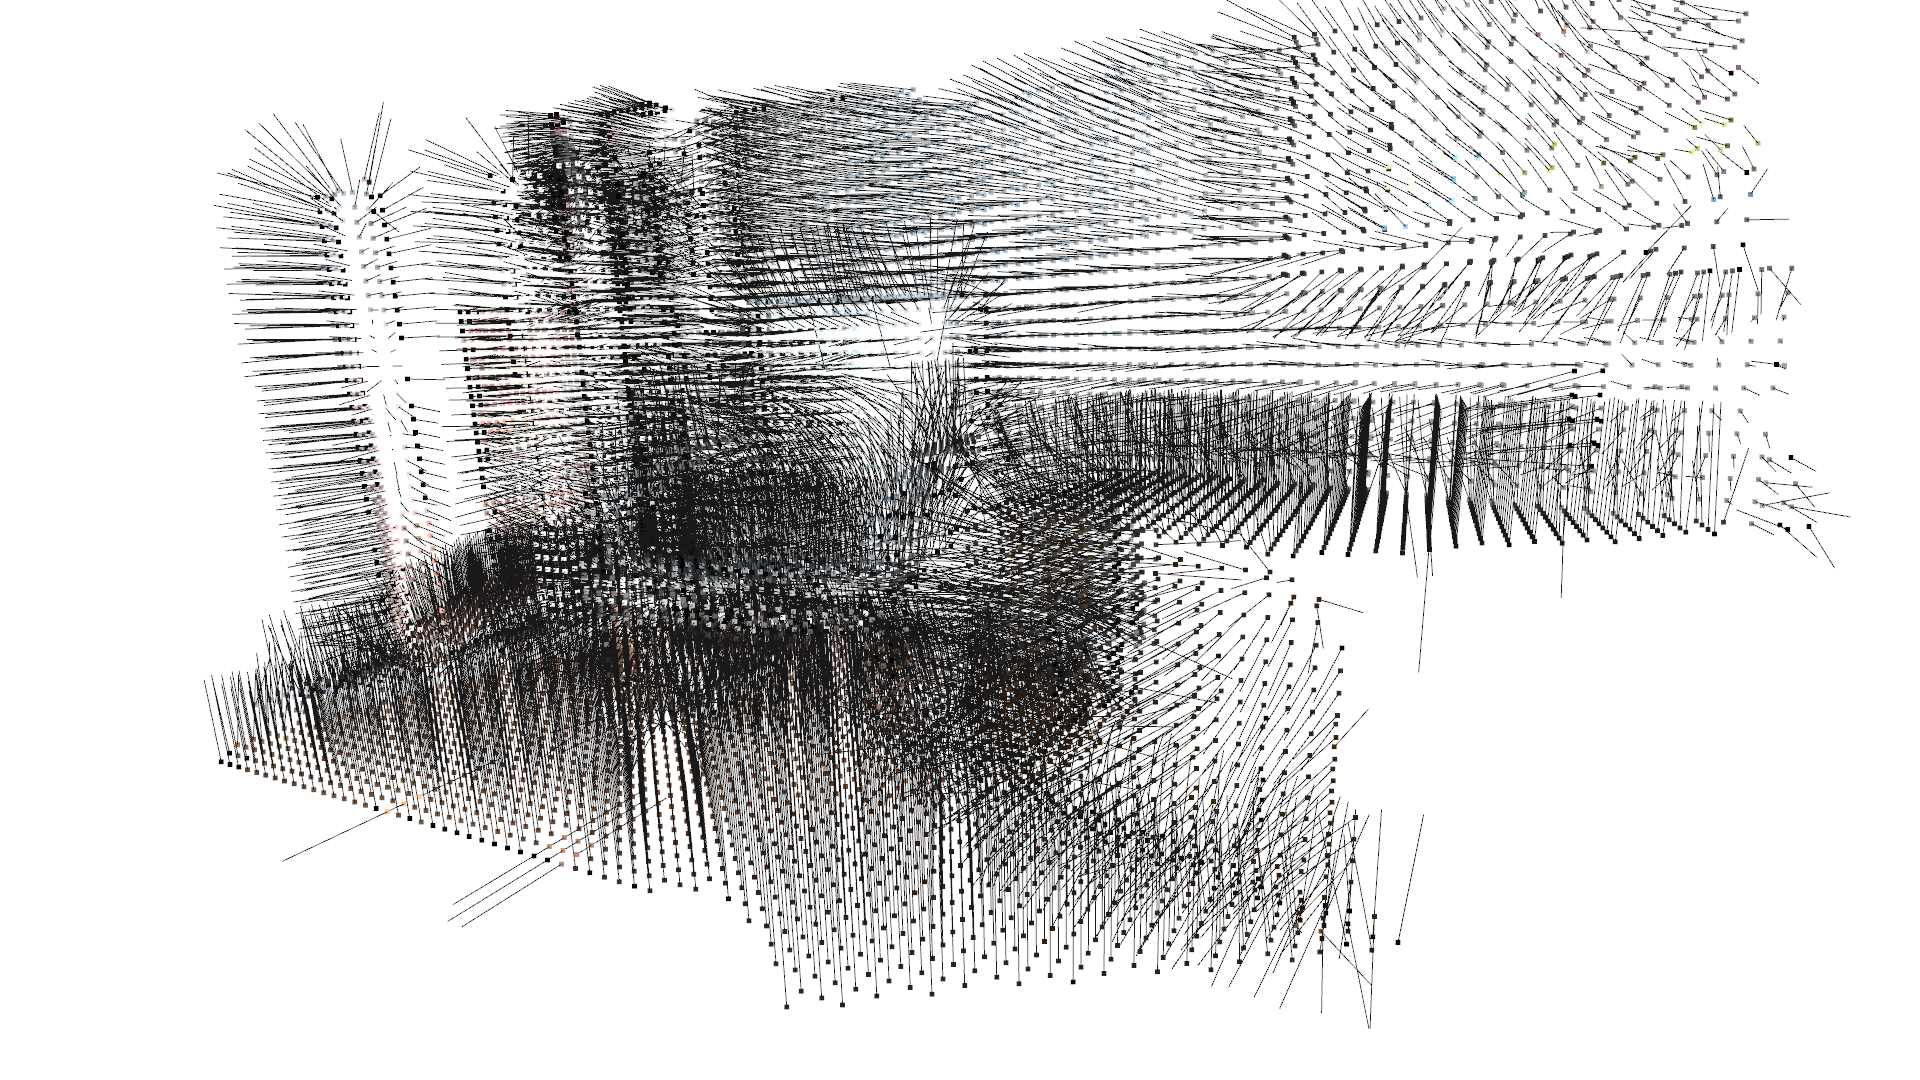

In [7]:
print("Recompute the normal of the downsampled point cloud using hybrid nearest neighbor search with 30 max_nn and radius of 0.1m.")
downpcd.estimate_normals(max_nn=30, radius=0.1)
o3d.visualization.draw_geometries([downpcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=True)

`estimate_normals` computes the normal for every point. The function finds adjacent points and calculates the principal axis of the adjacent points using covariance analysis.

The two key arguments `radius = 0.1` and `max_nn = 30` specifies search radius and maximum nearest neighbor. It has 10cm of search radius, and only considers up to 30 neighbors to save computation time. If only `max_nn` or `radius` is specified, the function will use knn or radius search respectively. 

<div class="alert alert-info">
    
**Note:** 
It is always recommended to specify both `radius` and `max_nn`, especially if the point cloud is on CUDA device.
</div>

<div class="alert alert-info">
    
**Note:** 
The covariance analysis algorithm produces two opposite directions as normal candidates. Without knowing the global structure of the geometry, both can be correct. This is known as the normal orientation problem. Open3D tries to orient the normal to align with the original normal if it exists. Otherwise, Open3D does a random guess. Further orientation functions such as `orient_normals_to_align_with_direction` and `orient_normals_towards_camera_location` need to be called if the orientation is a concern.

</div>

### Access estimated normals
The estimated normals can be access and converted to numpy array.

In [25]:
normals = downpcd.point.normals
print('Print first 5 normals of the downsampled point cloud.')
print(normals[:5], '\n')
print('Convert normals tensor into numpy array.')
normals_np = normals.numpy()
print(normals_np[:5])

Print first 5 normals of the downsampled point cloud.
[[-0.501699 0.126191 -0.855789],
 [-0.428905 0.104427 -0.897293],
 [-0.396863 0.0474221 -0.916652],
 [-0.488195 0.102253 -0.866724],
 [-0.408576 0.240975 -0.880339]]
Tensor[shape={5, 3}, stride={3, 1}, Float32, CPU:0, 0x55be45cf3e40] 

Convert normals tensor into numpy array.
[[-0.5016988   0.12619077 -0.85578865]
 [-0.42890513  0.10442688 -0.8972932 ]
 [-0.39686304  0.04742212 -0.916652  ]
 [-0.48819506  0.10225325 -0.86672354]
 [-0.40857556  0.24097526 -0.880339  ]]


## Crop point cloud

In [9]:
print("Load a polygon volume and use it to crop the original point cloud")
demo_crop_data = o3d.data.DemoCropPointCloud()
pcd = o3d.t.io.read_point_cloud(demo_crop_data.point_cloud_path)
vol = o3d.visualization.read_selection_polygon_volume(demo_crop_data.cropped_json_path)
chair = vol.crop_point_cloud(pcd.to_legacy())
o3d.visualization.draw_geometries([chair],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

Load a polygon volume and use it to crop the original point cloud


`read_selection_polygon_volume` reads a json file that specifies polygon selection area. `vol.crop_point_cloud(pcd)` filters out points. Only the chair remains.

We can also get the cropped indices of the point cloud using `crop_in_polygon`. 

In [29]:
indices = vol.crop_in_polygon(pcd.to_legacy())
print(f'Cropped indices length: {len(indices)}') 

Cropped indices length: 31337


## Paint point cloud

In [32]:
print("Paint point cloud.")
pcd = pcd.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

Paint point cloud.


`paint_uniform_color` paints all the points to a uniform color. The color is in RGB space, [0, 1] range.

## Bounding volumes
The `PointCloud` geometry type has bounding volumes as all other geometry types in Open3D. Currently, Open3D implements an `AxisAlignedBoundingBox` and an `OrientedBoundingBox` that can also be used to crop the geometry.

In [36]:
aabb = pcd.get_axis_aligned_bounding_box()
aabb.set_color(o3c.Tensor([1, 0, 0], o3c.float32))
# obb = pcd.get_oriented_bounding_box()
# obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([pcd.to_legacy(), aabb.to_legacy()],
                                  zoom=0.7,
                                  front=[0.5439, -0.2333, -0.8060],
                                  lookat=[2.4615, 2.1331, 1.338],
                                  up=[-0.1781, -0.9708, 0.1608])

## Point cloud outlier removal
When collecting data from scanning devices, the resulting point cloud tends to contain noise and artifacts that one would like to remove. This demo below addresses the outlier removal features of Open3D.

### Prepare input data
A point cloud is loaded and downsampled using `voxel_downsample`.

In [30]:
print("Load a ply point cloud, print it, and render it")
sample_pcd_data = o3d.data.PCDPointCloud()
pcd = o3d.t.io.read_point_cloud(sample_pcd_data.path)
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

print("Downsample the point cloud with a voxel of 0.02")
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.02)
o3d.visualization.draw_geometries([voxel_down_pcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Load a ply point cloud, print it, and render it
Downsample the point cloud with a voxel of 0.02


Alternatively, use `uniform_down_sample` to downsample the point cloud by collecting every n-th points.

In [31]:
print("Every 5th points are selected")
uni_down_pcd = pcd.uniform_down_sample(every_k_points=5)
o3d.visualization.draw_geometries([uni_down_pcd.to_legacy()],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Every 5th points are selected


### Select down sample
The following helper function uses `select_by_mask`, which takes a binary mask to output only the selected points. The selected points and the non-selected points are visualized.

In [34]:
def display_inlier_outlier(cloud : o3d.t.geometry.PointCloud, mask : o3c.Tensor):
    inlier_cloud = cloud.select_by_mask(mask)
    outlier_cloud = cloud.select_by_mask(mask, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud = outlier_cloud.paint_uniform_color([1.0, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    inlier_cloud = o3d.visualization.draw_geometries([inlier_cloud.to_legacy(), outlier_cloud.to_legacy()],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

### Radius outlier removal
`radius_outlier_removal` removes points that have few neighbors in a given sphere around them. Two parameters can be used to tune the filter to your data:

- `nb_points`, which lets you pick the minimum amount of points that the sphere should contain.
- `radius`, which defines the radius of the sphere that will be used for counting the neighbors.

In [35]:
# TODO: StatisticalOutlierRemoval is not implemented yet.
print("Radius oulier removal")
cl, ind = voxel_down_pcd.remove_radius_outliers(nb_points=16, search_radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

Radius oulier removal
Showing outliers (red) and inliers (gray): 


## Convex hull
The convex hull of a point cloud is the smallest convex set that contains all points. Open3D contains the method `compute_convex_hull` that computes the convex hull of a point cloud. The implementation is based on [Qhull](http://www.qhull.org/).

In the example code below we compute the convex hull that is returned as a triangle mesh. Then, we visualize the convex hull as a red `LineSet`.

In [38]:
bunny = o3d.data.BunnyMesh()
pcd = o3d.t.io.read_point_cloud(bunny.path)

hull = pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull.to_legacy())
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([pcd.to_legacy(), hull_ls])

## DBSCAN clustering
Given a point cloud from e.g. a depth sensor we want to group local point cloud clusters together. For this purpose, we can use clustering algorithms. Open3D implements DBSCAN [\[Ester1996\]](../reference.html#Ester1996) that is a density based clustering algorithm. The algorithm is implemented in `cluster_dbscan` and requires two parameters: `eps` defines the distance to neighbors in a cluster and `min_points` defines the minimum number of points required to form a cluster. The function returns `labels`, where the label `-1` indicates noise.

In [42]:
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.t.io.read_point_cloud(ply_point_cloud.path)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True)

max_label = labels.max().item()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(
        labels.numpy() / (max_label if max_label > 0 else 1))
colors = o3c.Tensor(colors[:, :3], o3c.float32)
colors[labels < 0] = 0
pcd.point.colors = colors
o3d.visualization.draw_geometries([pcd.to_legacy()],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[========================================] 100%
[Open3D DEBUG] Done Compute Clusters: 10==========>] 97%
point cloud has 10 clusters


<div class="alert alert-info">
    
**Note:** 

This algorithm precomputes all neighbors in the epsilon radius for all points. This can require a lot of memory if the chosen epsilon is too large.

</div>

## Plane segmentation
Open3D also supports segmententation of geometric primitives from point clouds using RANSAC. To find the plane with the largest support in the point cloud, we can use `segment_plane`. The method has four arguments: `distance_threshold` defines the maximum distance a point can have to an estimated plane to be considered an inlier, `ransac_n` defines the number of points that are randomly sampled to estimate a plane, `num_iterations` defines how often a random plane is sampled and verified, and `probability` defined the expected probability of finding the optimal plane. The function then returns the plane as $(a,b,c,d)$ such that for each point $(x,y,z)$ on the plane we have $ax + by + cz + d = 0$. The function further returns a indices of the inlier points.

In [11]:
sample_pcd_data = o3d.data.PCDPointCloud()
pcd = o3d.t.io.read_point_cloud(sample_pcd_data.path)
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                            ransac_n=3,
                                            num_iterations=1000, 
                                            probability=0.9999)
[a, b, c, d] = plane_model.numpy().tolist()
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud = inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud.to_legacy(), outlier_cloud.to_legacy()],
                                  zoom=0.8,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

Plane equation: -0.06x + -0.10y + 0.99z + -1.06 = 0


## Hidden point removal
Imagine you want to render a point cloud from a given view point, but points from the background leak into the foreground because they are not occluded by other points. For this purpose we can apply a hidden point removal algorithm. In Open3D the method by [\[Katz2007\]](../reference.html#Katz2007) is implemented that approximates the visibility of a point cloud from a given view without surface reconstruction or normal estimation.

In [13]:
print("Convert mesh to a point cloud and estimate dimensions")
armadillo = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo.path)
# Tensor TriangleMesh not supported this function yet.
mesh.compute_vertex_normals()

pcd = mesh.sample_points_poisson_disk(5000)
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
o3d.visualization.draw_geometries([pcd])

print("Define parameters used for hidden_point_removal")
camera = o3d.core.Tensor([0, 0, diameter], o3d.core.float32)
radius = diameter * 100

print("Get all points that are visible from given view point")
pcd = o3d.t.geometry.PointCloud.from_legacy(pcd)
_, pt_map = pcd.hidden_point_removal(camera, radius)
pcd = pcd.select_by_index(pt_map)

print("Visualize result")
o3d.visualization.draw_geometries([pcd.to_legacy()])

Convert mesh to a point cloud and estimate dimensions
Define parameters used for hidden_point_removal
Get all points that are visible from given view point
Visualize result


## Boundary Detection
Open3D implements the boundary detection algorithm inspired by [PCL](https://pointclouds.org/documentation/classpcl_1_1_boundary_estimation.html). The algorithm find the boundary points among a unordered point cloud by analysising the angle between the normals of a point and its neighbors. The method has four arguments: `radius` and `max_nn` specify the hybrid nearest search parameters. The `angle_threshold` defines the maximum angle between the normals of a point and its neighbors to be considered a boundary point. The functions returns the boundary points and a boolean tensor of the same size as the input point cloud, where `True` indicates a boundary point.

In [28]:
ply_point_cloud = o3d.data.DemoCropPointCloud()
pcd = o3d.t.io.read_point_cloud(ply_point_cloud.point_cloud_path)

boundarys, mask = pcd.compute_boundary_points(0.02, 30)
# TODO: not good to get size of points.
print(f"Detect {boundarys.point.positions.shape[0]} bnoundary points from {pcd.point.positions.shape[0]} points.")

boundarys = boundarys.paint_uniform_color([1.0, 0.0, 0.0])
pcd = pcd.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([pcd.to_legacy(), boundarys.to_legacy()],
                                      zoom=0.3412,
                                      front=[0.3257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

Detect 10846 noundary points from 196133 points
